In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt; plt.rc('font', size=16)
import matplotlib.cm as cm
import gLV_diet

cols = [cm.tab10(i) for i in range(10)]
cols.append(cm.Set2(5))
cols.append(cm.Paired(4))

# Test de la implementación del algoritmo de ajuste por mínimos cuadrados

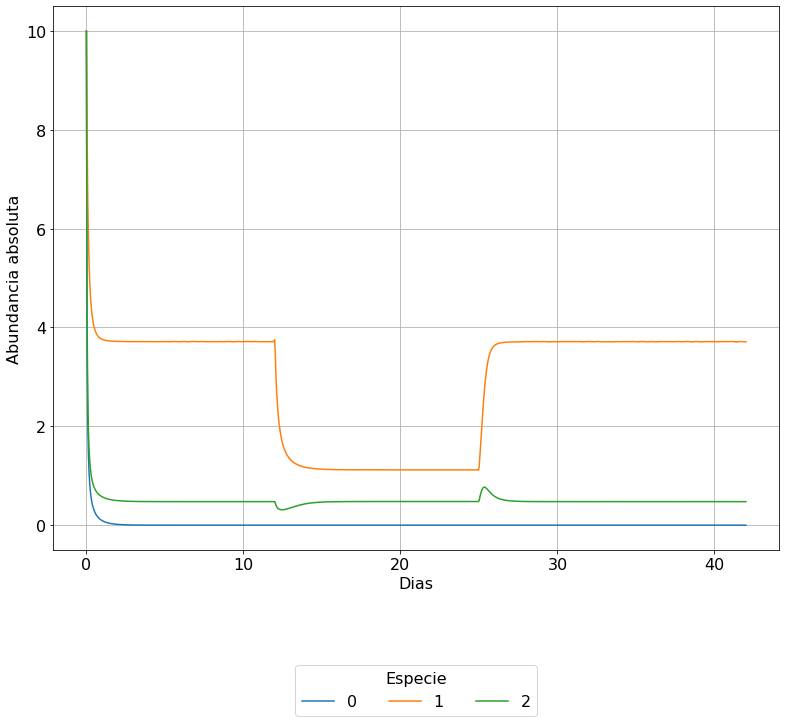

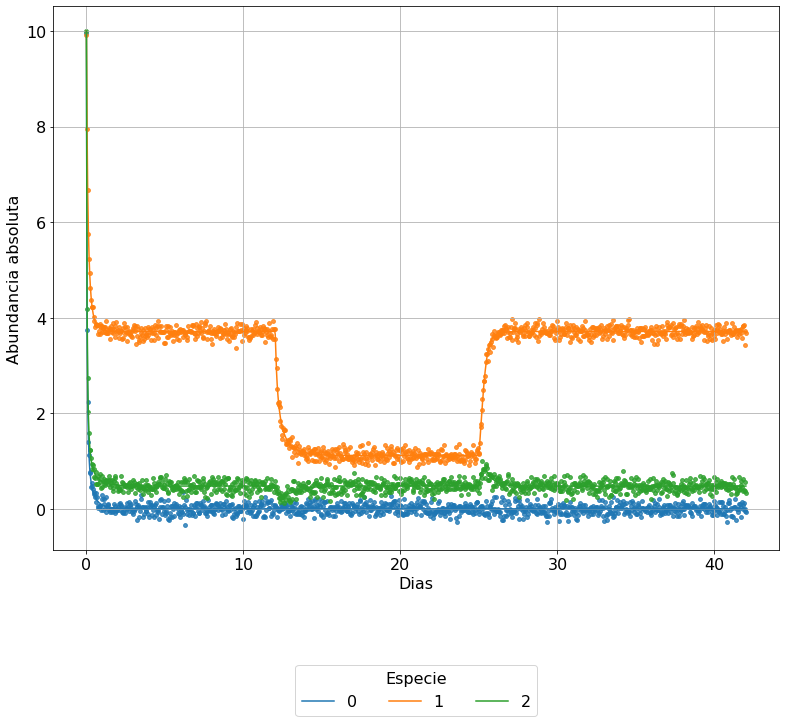

In [5]:
species=range(3)
x0=np.ones(len(species))*10
t_span=[0, 42]
t_span = [0, 42]
t_eval = np.linspace(t_span[0], t_span[-1], 1000)

test1 = gLV_diet.TestData(species, x0, t_span, t_eval)
test1.params
test1.dynamics_simulation()
test1.noisy_data()
test1.fit_gLV()
test1.plot_dynamics()
plt.show()
test1.plot_trajectories(x_log=False)
plt.show()

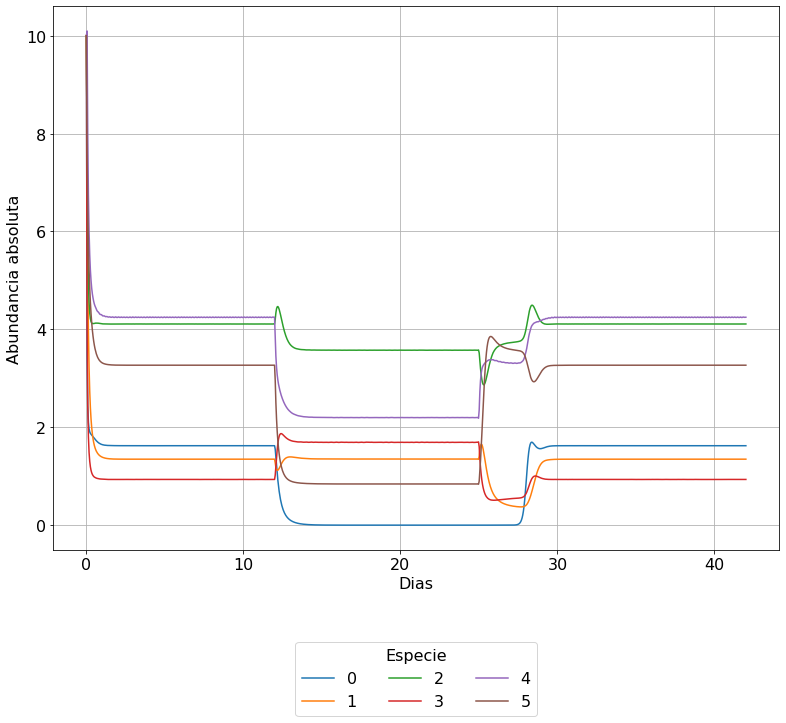

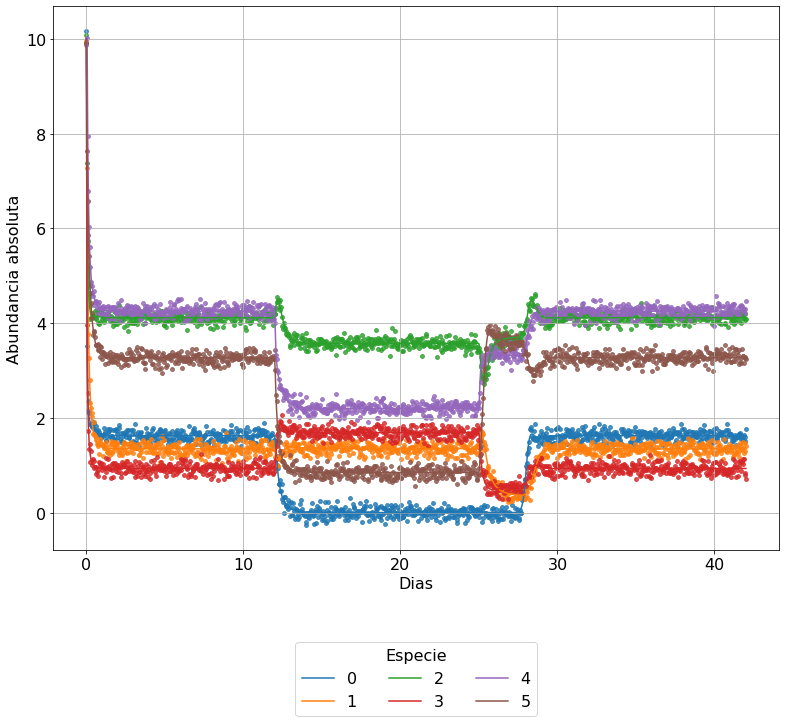

In [6]:
species=range(6)
x0=np.ones(len(species))*10
t_span=[0, 42]
t_span = [0, 42]
t_eval = np.linspace(t_span[0], t_span[-1], 1000)

test1 = gLV_diet.TestData(species, x0, t_span, t_eval)
test1.params
test1.dynamics_simulation()
test1.noisy_data()
test1.fit_gLV()
test1.plot_dynamics()
plt.show()
test1.plot_trajectories(x_log=False)
plt.show()

---
# Réplicación de resultados de Stein et al., 2013. PLoS Biology

In [7]:
mu = pd.read_excel('Stein2013_Dataset_S1.xlsx', sheet_name='mu', index_col=0)
alpha = pd.read_excel('Stein2013_Dataset_S1.xlsx', sheet_name='alpha', index_col=0)
beta = pd.read_excel('Stein2013_Dataset_S1.xlsx', sheet_name='beta', index_col=0)
data = pd.read_excel('Stein2013_Dataset_S1.xlsx', sheet_name='data', index_col=0).T

In [8]:
species = mu.index
growth = mu.values.T[0]
cross_int = alpha.values
susceptibility = beta.values.T[0]
x0 = data[data['Replicate'] == 2][data['Population'] == 3][data['time (in d)'] == 0].T.iloc[4:15,:].values.T[0]*1e11
x0[8] = 1e4
t_eval = data[data['Replicate'] == 2][data['Population'] == 3]['time (in d)'].unique()
t_span = [t_eval[0], t_eval[-1]]

/tmp/ipykernel_93714/3015506098.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x0 = data[data['Replicate'] == 2][data['Population'] == 3][data['time (in d)'] == 0].T.iloc[4:15,:].values.T[0]*1e11
/tmp/ipykernel_93714/3015506098.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  t_eval = data[data['Replicate'] == 2][data['Population'] == 3]['time (in d)'].unique()


In [9]:
stein2013 = gLV_diet.TestData(species, x0, t_span, t_eval, treatment='Stein2013')
stein2013.define_params(growth, cross_int, susceptibility)

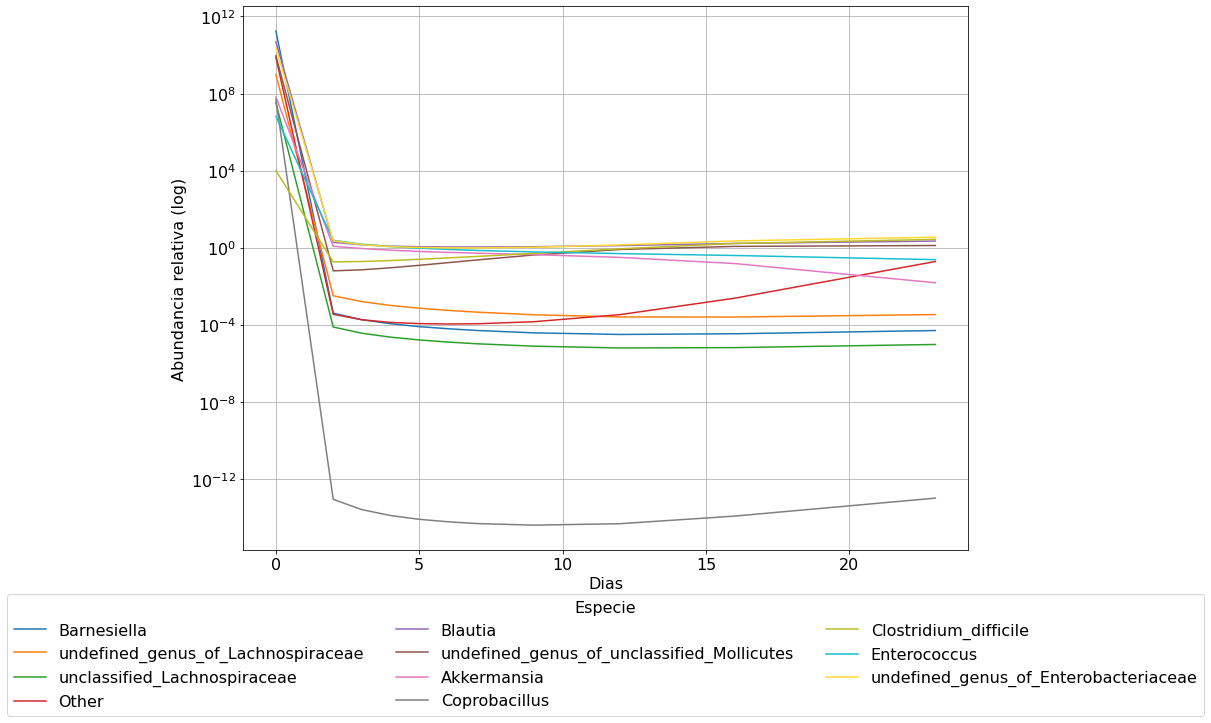

In [10]:
stein2013.dynamics_simulation()
stein2013.plot_dynamics(x_log=True)
plt.show()

***
# Ajuste a mis datos

In [11]:
data = pd.read_pickle('COPROseq_absolute_abundance.pkl')
data

,Strain,Treatment,Day,Absolute_abundance
0,B. caccae,LF0,1,5.151164e+07
1,B. cellulosilyticus WH2,LF0,1,7.110996e+07
2,B. ovatus,LF0,1,8.427954e+07
3,B. thetaiotaomicron,LF0,1,3.218013e+07
4,B. uniformis,LF0,1,7.739366e+06
...,...,...,...,...
4495,C. scindens,HF0,42,4.633884e+07
4496,C. spiroforme,HF0,42,8.481661e+05
4497,D. longicatena,HF0,42,3.302648e+04
4498,P. distasonis,HF0,42,3.108796e+07


In [20]:
LF0 = gLV_diet.Experiment(data, treatment='LF0')
HF0 = gLV_diet.Experiment(data, treatment='HF0')

In [21]:
report_fit(LF0.fit_gLV())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 169
    # data points      = 2100
    # variables        = 168
    chi-square         = 4.8537e+20
    reduced chi-square = 2.5123e+17
    Akaike info crit   = 84297.6686
    Bayesian info crit = 85246.8169
##  Warning: uncertainties could not be estimated:
    growth_1:           at initial value
    susceptibility_1:   at initial value
    cross_int_1_1:      at initial value
    cross_int_1_2:      at initial value
    cross_int_1_3:      at initial value
    cross_int_1_4:      at initial value
    cross_int_1_5:      at initial value
    cross_int_1_6:      at initial value
    cross_int_1_7:      at initial value
    cross_int_1_8:      at initial value
    cross_int_1_9:      at initial value
    cross_int_1_10:     at initial value
    cross_int_1_11:     at initial value
    cross_int_1_12:     at initial value
    growth_2:           at initial value
    susceptibility_2:   at initial value
    cross